# GCN 모델에 대한 핵심 요약

참조영상: https://www.youtube.com/watch?v=YL1jGgcY78U  
코드참조: https://www.youtube.com/watch?v=htTt4iPJqMg&t=2494s  
PPT자료: https://github.com/heartcored98/Standalone-DeepLearning/blob/master/Lec9/Lec9-A.pdf

Basic Graph Convolutional Network 모델에 대해서 간략하게 알아봅니다.  
(*CNN에 대한 사전 지식이 있다는 전제하에 설명합니다.*)

## Concept

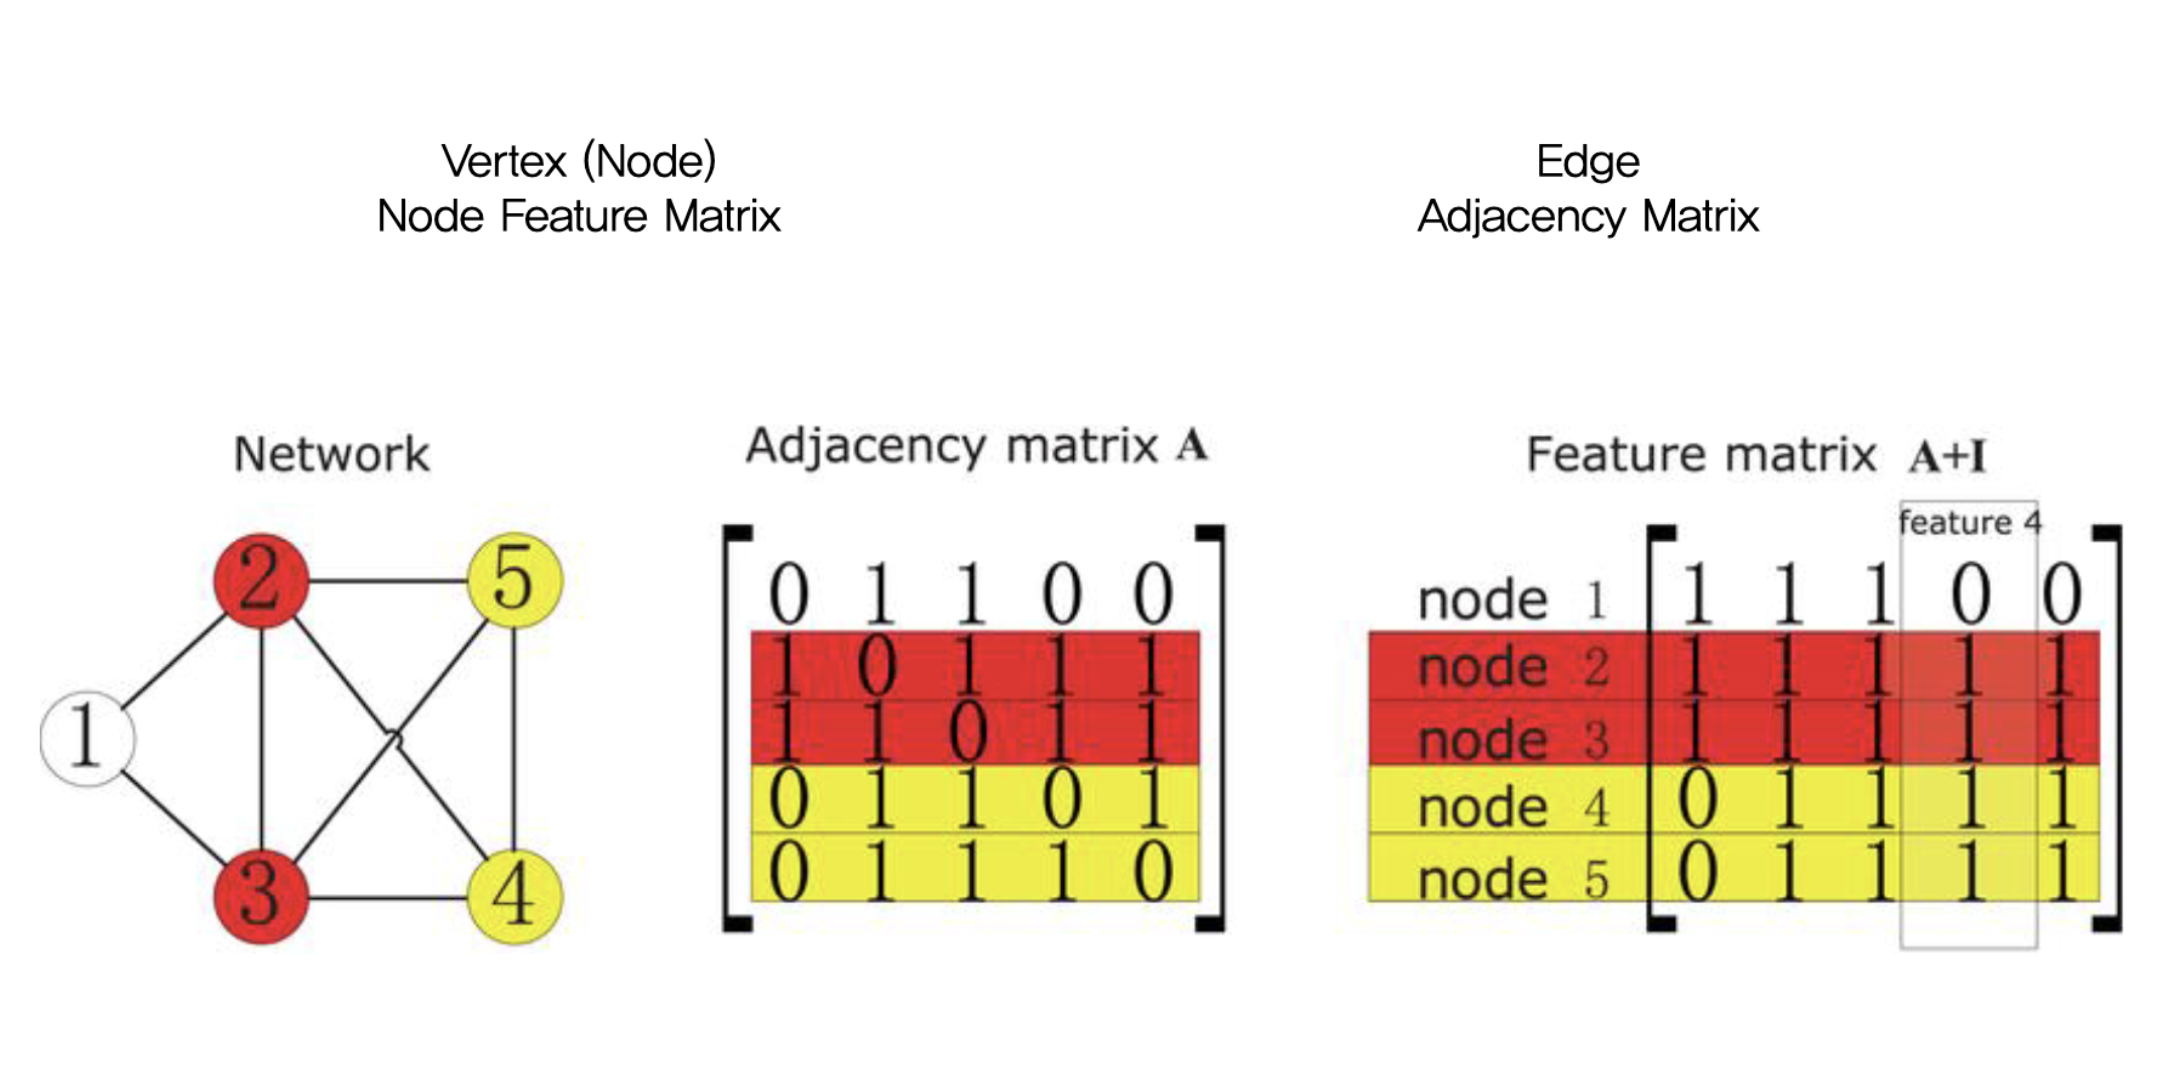

각 노드에 대한 정보와 노드 간 관계를 Graph로 정의하면 위 그림과 같이 표현할 수 있다.  
해당 설명에서는 SNS에서 유저에 대한 정보를 Graph로 표현했다고 가정해본다.  

**용어 정리:**
- Vertex(Node): 유저 하나하나를 의미함
- Edge: 유저와 유저 사이를 잇는 선
    - Edge를 화살표로 표기하여 방향성을 정의할 수 있음
    - Edge에 값을 기입하여 유저 간 상호작용에 대한 정보를 담을 수 있음
- Adjacency matrix: row와 column index를 유저로 설정했을 때 유저 간의 Connection을 boolean으로 표기하고 있다.
- Feature matrix: row는 유저, columns는 유저 정보(Feature)를 담는다.  


**Graph Structure:**

CNN의 아이디어를 Graph 데이터에 적용한다.  
- Weight Sharing: 
    - CNN에서 Filter(또는 Kernel) 사이즈를 정의해서 image의 local 정보를 Stride 설정 크기만큼 순차적으로 행렬곱을 해나가는 방식으로 전체 image 데이터를 학습하는 것을 알고 있을 것이다. 이 때 MLP처럼 픽셀별 weight가 1대1로 대응되는 방식이 아닌 nxn개의 weight가 공유되는 방식이므로 이를 weight sharing이라 한다.
    
- 어떤 방식으로 적용되는가?  
    - $H^{(1)} = \sigma(AH^{(0)}W^{(0)}+b^{(0)})$
        1. H 매트릭스는 Feature matrix(Node X Feature)에 해당한다. 해당 매트릭스를 W 매트릭스와 matmul을 진행하는데 여기서 W는 Node X Filter로 구성된 필터 모음집으로 볼 수 있다.  
            -> 각 유저의 정보를 F개의 필터를 적용한 결과를 뽑는다.
        2. H@W 연산의 결과로 Node X Filter 크기의 매트릭스가 생성되면 여기에 Adjacency matrix와 matmul한다.  
            -> 이는 노드 자신 그리고 이웃한 노드의 필터링 결과값만 선정하여 합을 취함을 의미하며 Graph에서 이웃한 노드의 데이터만 선택하는 방식이 CNN에서 local 영역에 대한 학습과 동일한 아이디어로서 적용된다.
        3. Activation Function을 거처 새로운 Feature Matrix(node X filter)가 생성된다.
    - 위 작업을 통해 하나의 row에 자신과 이웃한 노드의 정보가 합성된 정보가 새로운 매트릭스의 형태로 생성된다.

**Readout:**
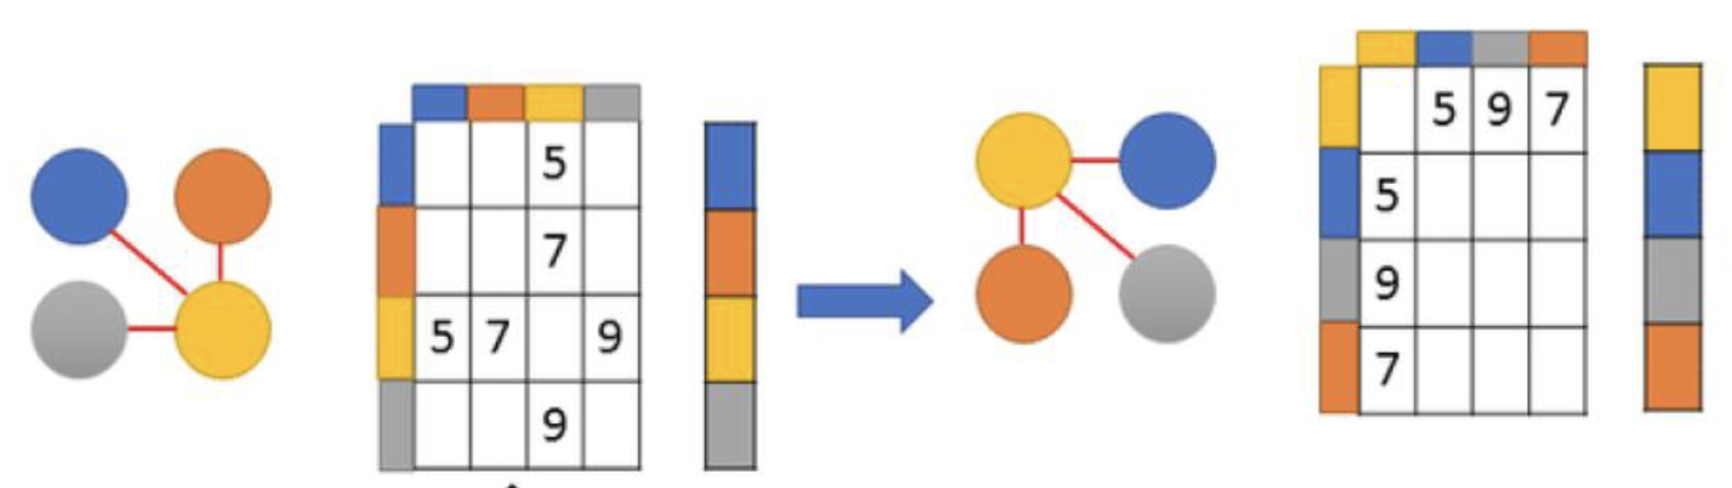
Permutation Invariance 문제를 해결하기 위해 적용되는 알고리즘이다.  
- 노드 간 connectivity 정보를 담은 매트릭스에서 유저 1(파란색 노드)이 첫번째 row와 column에 배치되었다가 두번째 row와 column에 배치된다 하더라도 다른 유저와의 연결 정보가 변경되어서는 안된다. 하지만 위 그림처럼 전혀 다른 값이 되기 때문에 유저의 매트릭스 자리 배치에 따른 차별이 없도록 permutation invariance 문제를 해결해야 한다.
- 여러 방법이 있다고 알려져 있으나 여기에서는 $Z_G = \tau(\sum_{i \in G}MLP(H_i^{(L)})$ 공식을 적용한다.

**Inception:**

GCN을 한 번 적용하면 각 노드의 이웃 관계에 있는 노드의 정보를 함께 학습하지만 두 번 적용하면 이웃의 이웃의 정보까지 학습에 포함된다. 이 떄 adjacency matrix가 한 번 더 연산됨으로 인한 효과라고 한다.

**Skip Connection**

ResNet 모델에 적용된 방식과 비슷하다. 이전 $H_0$가 새로운 Conv 레이어에 들어가서 나온 $H_1$과 더하는 방식으로 $H_0$의 identity를 계승하는 아이디어가 기본적인 Skip Connection의 의도이다. 하지만 여기에서는 *Gated Skip Connection*을 적용한다. 이는 $H_0$와 $H_1$ 합산 시 몇 대 몇의 비율로 합산할 것인가에 대한 정보를 부여하자는 아이디어가 담겨있다.

## Model Construction
위 강의에서는 원자 구조를 graph로 표현한 데이터를 예시로 코드가 작성되어 각 노드가 atom으로 불려진다는 점을 기억하자

**Model Process**

1. GCNLayer에서 adjacency matrix@(feature_matrix@filters) 연산을 진행 (init.xavier, ReLU 적용됨)
2. batch normalization 진행 (선택사항)
3. 1, 2번을 n_layer로 설정한 개수 만큼 생성 (GCNLayer 1 ~ n)
4. n개의 GCNLayer를 ModuleList를 통해 리스트처럼 보관
5. for문으로 ModuleList에 담긴 n개의 GCNLayer를 순차적으로 꺼내면서 skip connection을 수행(마지막 out은 활성함수 적용하지 않음)
    - 처음에는 input_X + GCNLayer_1_out = out1을 도출, 그 뒤로는 out1 + GCNLayer_2_out = out2가 되는 방식으로 n번 수행
6. 3~5과정(GCNBlock)을 마친 최종 out에 Readout 적용하여 vector를 out
7. Predictor클래스(사실상 그냥 nn.layer)로 추가 MLP를 적용하여 task에 부합하는 예측값 도출

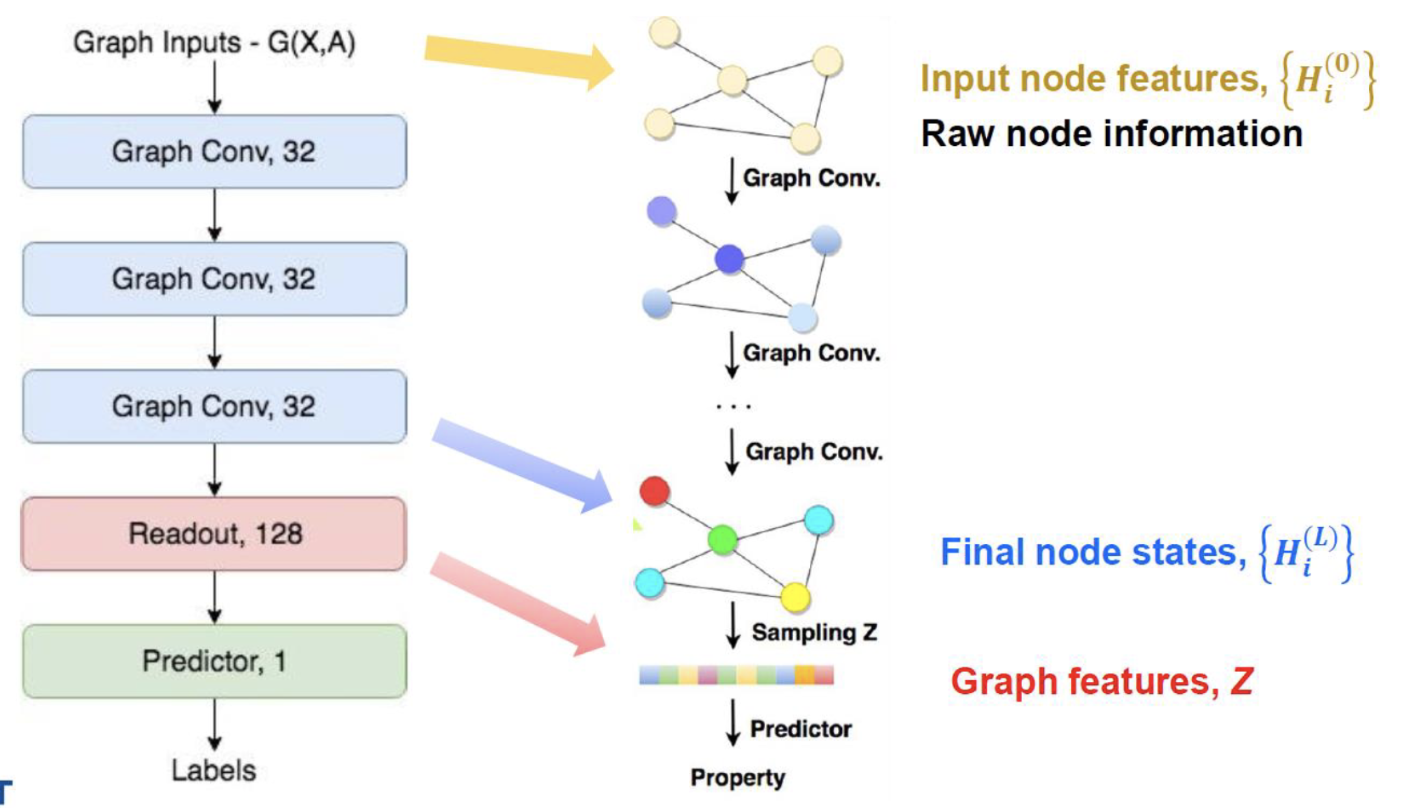

In [1]:
import torch
import torch.nn as nn

### GCNLayer
>node feature matrix와 adjacency matrix의 list를 받아 graph convolution 연산을 수행하는 module 입니다.

In [2]:
class GCNLayer(nn.Module):
    
    def __init__(self, in_dim, out_dim, n_atom, act=None, bn=False):
        super(GCNLayer, self).__init__()
        
        self.use_bn = bn # batch normalization 적용 유무
        self.linear = nn.Linear(in_dim, out_dim)
        nn.init.xavier_uniform_(self.linear.weight) # weight init
        self.bn = nn.BatchNorm1d(n_atom)
        self.activation = act
        
    def forward(self, x, adj):
        out = self.linear(x) # feature matrix @ Filters
        out = torch.matmul(adj, out) # adjacency matrix 
        if self.use_bn:
            out = self.bn(out)
        if self.activation != None:
            out = self.activation(out)
        return out, adj

### (Gated)SkipConnection 
> ResNet에서 사용되었던 skip connection technique을 구현한 module 입니다.

1. simple skip connection에는 H_0의 f(x)를 거친 H_1과의 차원수가 다를 경우 이를 맞춰주기 위한 linear가 추가 적용된다.
2. gated skip connection은 add 대상 매트릭스 두개를 각 linear layer에 입력, 결과를 더하여 sigmoid를 적용한다(z). 이를 데이터별 가중치로서 학습시키고 적용한다.

In [3]:
class SkipConnection(nn.Module):
    
    def __init__(self, in_dim, out_dim):
        super(SkipConnection, self).__init__()
        
        self.in_dim = in_dim
        self.out_dim = out_dim
        
        self.linear = nn.Linear(in_dim, out_dim, bias=False)
        
    def forward(self, in_x, out_x):
        if (self.in_dim != self.out_dim):
            in_x = self.linear(in_x)
        out = in_x + out_x
        return out

In [4]:
class GatedSkipConnection(nn.Module):
    
    def __init__(self, in_dim, out_dim):
        super(GatedSkipConnection, self).__init__()
        
        self.in_dim = in_dim
        self.out_dim = out_dim
        
        self.linear = nn.Linear(in_dim, out_dim, bias=False)
        self.linear_coef_in = nn.Linear(out_dim, out_dim)
        self.linear_coef_out = nn.Linear(out_dim, out_dim)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, in_x, out_x):
        if (self.in_dim != self.out_dim):
            in_x = self.linear(in_x)
        z = self.gate_coefficient(in_x, out_x)
        out = torch.mul(z, out_x) + torch.mul(1.0-z, in_x)
        return out
            
    def gate_coefficient(self, in_x, out_x):
        x1 = self.linear_coef_in(in_x)
        x2 = self.linear_coef_out(out_x)
        return self.sigmoid(x1+x2)

### GCNBlock
>node feature matrix와 adjacency matrix의 list를 받아 원하는 갯수의 GCNLayer를 통과시킨 후, (gated)skip connection을 적용하는 module 입니다.

In [59]:
class GCNBlock(nn.Module):
    def __init__(self, n_layer, in_dim, hidden_dim, out_dim, n_atom, bn=True, sc='gsc'):
        super(GCNBlock, self).__init__()
        
        self.layers = nn.ModuleList()
        for i in range(n_layer):
            self.layers.append(GCNLayer(in_dim if i==0 else hidden_dim,
                                        out_dim if i==n_layer-1 else hidden_dim, 
                                        n_atom, 
                                        nn.ReLU() if i!=n_layer-1 else None, 
                                        bn)
                              )
        self.relu == nn.ReLU()
        if sc=='gsc':
            self.sc = GatedSkipConnection(in_dim, out_dim)
        elif sc=='sc':
            self.sc = SkipConnection(in_dim, out_dim)
        elif sc=='no':
            self.sc = None
        else:
            assert False, "Wrong sc type."
        
    def forward(self, x, adj):
        residual = x
        for i, layer in enumerate(self.layers):
            out, adj = layer((x if i==0 else out), adj)
        if self.sc != None: # residual connection(skip connection)
            out = self.sc(residual, out)
        out = self.relu(out)
        return out, adj
        

### ReadOut
>graph structrure에 permutation invariance를 주기 위하여 linear layer를 거친 뒤 batch 별로 summation하는 module 입니다.

In [ ]:
class ReadOut(nn.Module):
    
    def __init__(self, in_dim, out_dim, act=None):
        super(ReadOut, self).__init__()
        
        self.in_dim = in_dim
        self.out_dim= out_dim
        
        self.linear = nn.Linear(self.in_dim, 
                                self.out_dim)
        nn.init.xavier_uniform_(self.linear.weight)
        self.activation = act

    def forward(self, x):
        out = self.linear(x)
        out = torch.sum(out, axis=1)
        if self.activation != None:
            out = self.activation(out)
        return out

### Predictor
>ReadOut layer로부터의 graph feature vector로부터 logP value를 예측하기 위한 linear layer module 입니다.

In [ ]:
class Predictor(nn.Module):
    
    def __init__(self, in_dim, out_dim, act=None):
        super(Predictor, self).__init__()
        
        self.in_dim = in_dim
        self.out_dim = out_dim
        
        self.linear = nn.Linear(self.in_dim,
                                self.out_dim)
        nn.init.xavier_uniform_(self.linear.weight)
        self.activation = act
        
    def forward(self, x):
        out = self.linear(x)
        if self.activation != None:
            out = self.activation(out)
        return out

### GCNNet
> 최종 모델 구조

In [ ]:
class GCNNet(nn.Module):
    
    def __init__(self, args):
        super(GCNNet, self).__init__()
        
        self.blocks = nn.ModuleList()
        for i in range(args.n_block):
            self.blocks.append(GCNBlock(args.n_layer,
                                        args.in_dim if i==0 else args.hidden_dim,
                                        args.hidden_dim,
                                        args.hidden_dim,
                                        args.n_atom,
                                        args.bn,
                                        args.sc))
        self.readout = ReadOut(args.hidden_dim, 
                               args.pred_dim1,
                               act=nn.ReLU())
        self.pred1 = Predictor(args.pred_dim1,
                               args.pred_dim2,
                               act=nn.ReLU())
        self.pred2 = Predictor(args.pred_dim2,
                               args.pred_dim3,
                               act=nn.Tanh())
        self.pred3 = Predictor(args.pred_dim3,
                               args.out_dim)
        
    def forward(self, x, adj):
        for i, block in enumerate(self.blocks):
            out, adj = block((x if i==0 else out), adj)
        out = self.readout(out)
        out = self.pred1(out)
        out = self.pred2(out)
        out = self.pred3(out)
        return out